# Predicting NYC apartment's value with open data

**tldr;** Boldly predict a NYC apartments market value using only public / open data. Check out the [Price Predictor](#Price-Predictor).


Any good brokers in NYC will use a variety of factors to determine the value of your apartment, including:

1. Recent sales in your building / Neighbourhood
2. Square footage
3. Renovation status
4. View, closeness to subway, # of bedrooms etc. 

Unfortunately this data, is not easily available for the purposes of analysis. Note: it's available on Streeteasy and other REBNY memebers but not easily available for data analysis.

Here I present an alternative approach to pricing NYC apartments with only public data from [NYC Open Data](https://opendata.cityofnewyork.us/). 


In [1]:
import numpy as np
import pandas as pd
import datetime
from scipy.spatial import distance

import ipywidgets as widgets
from ipywidgets import IntSlider

from datascience import *
from datetime import timedelta
from datetime import date
from datetime import datetime
import time

from IPython.display import display
from IPython.display import HTML

# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')


import locale
%load_ext line_profiler
import os
import xlrd as xlrd

# Constants

Let's define some constants to help make our code more readable

In [2]:


# Constants
raw_directory = "input/"
output_directory = "output/"


# Declare column names to allow for auto completion :)

COL_SALE_DATE = 'SALE DATE'

COL_PURCHASE_DATE = 'PURCHASE DATE'
COL_SOLD_DATE = 'SOLD DATE'
COL_PURCHASE_PRICE = 'PURCHASE PRICE'
COL_SOLD_PRICE = 'SOLD PRICE'
COL_FULL_ADDRESS = 'FULL ADDRESS'
COL_PRICE_CHANGE = 'PRICE CHANGE'
COL_PERIOD = 'PERIOD'

COL_SALE_YEAR = 'SALE_YEAR'
COL_SALE_MONTH = 'SALE_MONTH'
COL_SALE_PRICE = 'SALE PRICE'

COL_PRICE_PERCENT = 'PRICE CHANGE %'


# Daily price change column name
COL_DAILY_PRICE_CHANGE = 'DAILY PRICE CHANGE'

COL_PURCHASE_DATE_SU = 'PURCHASE DATE SU'
COL_PURCHASE_PRICE_SU = 'PURCHASE PRICE SU'
COL_SOLD_DATE_SU = 'SOLD DATE SU'




# Functions

Also lets define some functions to assist in our analysis

In [3]:
# def original_value(original_values, sd_value ):
#     '''convert a standard unit value to it's original value'''

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)


def correlation(t, x, y):
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))


def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y)) / np.std(table.column(x))


def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))


def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b


def residual(table, x, y):
    return table.column(y) - fit(table, x, y)


def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)


# Helpers Functions

def print_stats(data):
    '''Prints common stats for a data array'''

    data_mean = np.mean(data)
    data_std = np.std(data)
    data_min = min(data)
    data_max = max(data)

    percent_5 = percentile(5, data)
    percent_95 = percentile(95, data)
    percent_1 = percentile(1, data)
    percent_99 = percentile(99, data)

    percent_25 = percentile(25, data)
    percent_50 = percentile(50, data)
    percent_75 = percentile(75, data)

    print("Avg:", data_mean, "\tStd:", data_std, "\tMin:", data_min, "\tMax:", data_max)
    print(" 5%:", percent_5, "\t95%:", percent_95)
    print(" 1%:", percent_1, "\t99%:", percent_99)
    print("25%:", percent_25, "\t50%:", percent_50, '\t75%', percent_75)


def print_col_stats(table, col_name):
    ''' Print the stats For column named'''

    print(col_name, "Stats")
    data = table.column(col_name)
    print_stats(data)


def draw_hist(table: Table, col_name, offset_percent=0):
    ''' Draw a histogram for table with an additional offset percent'''
    data = table.column(col_name)
    offset_start = percentile(offset_percent, data)
    offset_end = percentile(100 - offset_percent, data)
    table.hist(col_name, bins=np.arange(offset_start, offset_end, (offset_end - offset_start) / 20))


def col_stats(table, col_name):
    ''' Prints state for a column in table'''
    print_col_stats(table, col_name)
    draw_hist(table, col_name)


# Step 1: Import data

Sources
1. [Annualized Sales Data](https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page)
2. [Rolling Sale data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [4]:
# List data files and directories in current directory
excel_files = os.listdir(raw_directory)

# Select only tje xls files
excel_files = [k for k in excel_files if '.xls' in k]

In [5]:
excel_files[:len(excel_files)]

['2015_manhattan.xls',
 '2011_manhattan.xls',
 '2016_manhattan.xls',
 '2012_manhattan.xls',
 'rollingsales_manhattan.xls',
 'sales_manhattan_03.xls',
 'sales_manhattan_06.xls',
 'sales_manhattan_04.xls',
 'sales_2007_manhattan.xls',
 'sales_manhattan_05.xls',
 '2009_manhattan.xls',
 '2013_manhattan.xls',
 '2017_manhattan.xls',
 'sales_2008_manhattan.xls',
 '2010_manhattan.xls',
 '2014_manhattan.xls']

Unfortunately not all files are formatted the same way. Some have the header in row 4, others in row 5. We can check by making sure 'BOROUGH' is the first column in the imported dataset 

In [6]:

# Create an data store
all_sales_data = pd.DataFrame()

# Load individual excel files. 
for excel_file in excel_files:
    print(excel_file)
    
    # Read excel, Note the headers could in row 4 or row 5 (index=3 or 4). 
    yearly_sales_data = pd.read_excel(raw_directory+excel_file, header=3, encoding='sys.getfilesystemencoding()')
   
    # Check if the first column is "BOROUGH"
    if not yearly_sales_data.columns[0].startswith('BOROUGH'):
        # Otherwise the data starts from row 5.
         yearly_sales_data = pd.read_excel(raw_directory+excel_file, header=4, encoding='sys.getfilesystemencoding()')
    
#     print(yearly_sales_data.shape)
    
    yearly_sales_data.rename(columns=lambda x: x.strip(), inplace=True)
    
    all_sales_data = all_sales_data.append(yearly_sales_data)
    
#     print(all_sales_data.shape)

2015_manhattan.xls
2011_manhattan.xls
2016_manhattan.xls
2012_manhattan.xls
rollingsales_manhattan.xls
sales_manhattan_03.xls
sales_manhattan_06.xls
sales_manhattan_04.xls
sales_2007_manhattan.xls
sales_manhattan_05.xls
2009_manhattan.xls
2013_manhattan.xls
2017_manhattan.xls


/Users/somya/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


sales_2008_manhattan.xls
2010_manhattan.xls
2014_manhattan.xls


Spot check to verify data

In [7]:

all_sales_data.sample(10)


,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,EASE-MENT,...,NEIGHBORHOOD,RESIDENTIAL UNITS,SALE DATE,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE
9379,330 EAST 38TH STREET,8P,943,1,NaN,R4,R4,13 CONDOS - ELEVATOR APARTMENTS,0,,...,KIPS BAY,1,2007-10-09,899000,NaN,2,2,1,0,10016
25185,"250 WEST 89TH STREET, RES1",,1236,1,NaN,R9,R9,17 CONDOPS,0,,...,UPPER WEST SIDE (79-96),0,2006-12-22,375000,NaN,2,2,0,1986,10024
25821,"801 WEST END AVE., 8E",,1888,1,NaN,D4,D4,10 COOPS - ELEVATOR APARTMENTS,0,,...,UPPER WEST SIDE (96-116),0,2013-04-24,1500000,NaN,2,2,0,1940,10025
21035,"233 EAST 69TH STREET, 14H",,1424,1,NaN,R9,R9,17 CONDOPS,0,,...,UPPER EAST SIDE (59-79),0,2007-03-23,650000,NaN,2,2,0,1957,10021
131,5 AVENUE D,,372,1,NaN,V1,V1,31 COMMERCIAL VACANT LAND,0,,...,ALPHABET CITY,0,2008-09-25,0,NaN,4,4,0,0,10009
12307,768 5TH AVE,607,1274,1,NaN,R4,R4,13 CONDOS - ELEVATOR APARTMENTS,0,,...,MIDTOWN WEST,1,2006-04-07,0,NaN,2,2,1,0,10019
20409,"215 WEST 91 STREET, APT 121",,1239,1,NaN,D4,D4,10 COOPS - ELEVATOR APARTMENTS,0,,...,UPPER WEST SIDE (79-96),0,2003-01-21,0,NaN,2,2,0,1917,0
23918,240 RIVERSIDE BOULEVARD,5 F,1171,1,NaN,R4,R4,13 CONDOS - ELEVATOR APARTMENTS,0,,...,UPPER WEST SIDE (59-79),1,2013-11-15,1237500,NaN,2,2,1,0,10069
11371,200 EAST 66TH STREET,A0702,1420,1,NaN,R4,R4,13 CONDOS - ELEVATOR APARTMENTS,0,,...,UPPER EAST SIDE (59-79),1,2017-12-28,1500000,NaN,2,2,1,1951,10065
1602,112 EAST 10 STREET,,465,1,NaN,C4,C4,07 RENTALS - WALKUP APARTMENTS,0,,...,EAST VILLAGE,5,2004-01-21,1400000,NaN,2A,2,5,1900,10003


In [8]:
# Check for duplicate entries
sum(all_sales_data.duplicated(all_sales_data.columns))

16171

In [9]:
#Delete the duplicates and check that it worked
all_sales_data = all_sales_data.drop_duplicates(all_sales_data.columns, keep='last')
sum(all_sales_data.duplicated(all_sales_data.columns))

0

# Step 2. Clean up the data and arrange for analysis

In [10]:
#SALE DATE is object but should be datetime
all_sales_data[COL_SALE_DATE] = pd.to_datetime(all_sales_data[COL_SALE_DATE], errors='coerce')
all_sales_data['APARTMENT NUMBER'] = all_sales_data['APARTMENT NUMBER'].astype(str)

# remove additional whitespace in strings
all_sales_data = all_sales_data.applymap(lambda x: x.strip() if type(x) is str else x)

In [11]:
# Convert to Table for analysis
all_sales_data = Table.from_df(all_sales_data)

In [12]:
nov_sales = all_sales_data.where(COL_SALE_DATE, are.above_or_equal_to(datetime(2018, 11, 1)))

nov_sales.where('NEIGHBORHOOD', 'MIDTOWN EAST').select('ADDRESS', 'APARTMENT NUMBER', COL_SALE_PRICE ).show()

ADDRESS,APARTMENT NUMBER,SALE PRICE
304 EAST 52 STREET,,0
"425 EAST 50TH STREET, 2",,1195000
"225 EAST 47TH STREET, 2F",,3300000
"251 EAST 51ST STREET, 5B",,690000
"220 EAST 54TH STREET, 8L",,430000
"245 EAST 54TH STREET, 12R",,630000
"245 EAST 54TH STREET, 15P",,640000
"200 EAST 57TH STREET, 4N",,1500000
"305 EAST 40TH STREET, 19A",,460000
"25 TUDOR CITY PLACE, 309",,380350


In [13]:
# remove and sales less than $10,000 they are likely to be a property transfer rather than an actual sale
all_sales_data = all_sales_data.where(COL_SALE_PRICE, are.above(10000))

In [14]:
# SPOT CHECK: Understand the data labels we might be interested in
all_sales_data.labels

('ADDRESS',
 'APARTMENT NUMBER',
 'BLOCK',
 'BOROUGH',
 'BUILDING CLASS AS OF FINAL ROLL 17/18',
 'BUILDING CLASS AT PRESENT',
 'BUILDING CLASS AT TIME OF SALE',
 'BUILDING CLASS CATEGORY',
 'COMMERCIAL UNITS',
 'EASE-MENT',
 'GROSS SQUARE FEET',
 'LAND SQUARE FEET',
 'LOT',
 'NEIGHBORHOOD',
 'RESIDENTIAL UNITS',
 'SALE DATE',
 'SALE PRICE',
 'TAX CLASS AS OF FINAL ROLL 17/18',
 'TAX CLASS AT PRESENT',
 'TAX CLASS AT TIME OF SALE',
 'TOTAL UNITS',
 'YEAR BUILT',
 'ZIP CODE')

In [15]:
# Remove columns we don't actually need. e.g. lot, block etc

all_sales_data = all_sales_data.select(['SALE DATE', 'SALE PRICE', 'ADDRESS','APARTMENT NUMBER', 'YEAR BUILT', 'NEIGHBORHOOD', 'ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY'])

In [16]:
# Combine the Address and Apt No. The data here seems a little messy. Sometime the address itself contains the apt no,
# other times it's seperated. Let's create a full address column that combines them into a single address

def combine_address(address, aptNo):
    """Combine the address and Apartment into a single result"""
    temp = address.strip()
    if len(aptNo.strip()) > 0:
        temp = temp + ', ' + aptNo.strip()
    return temp

full_address = all_sales_data.apply(combine_address, ['ADDRESS', 'APARTMENT NUMBER'])

# Add a Full Address column
all_sales_data =  all_sales_data.with_column(COL_FULL_ADDRESS, full_address)

/Users/somya/Library/Python/3.7/lib/python/site-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


In [17]:
# Try to understand Building Class Codes. What are the most common Codes?

all_sales_data.group(['BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']).sort('count', descending=True).show(20)

# Ok mostly condos and co-ops as expected

# Question what's R5 -  COMMERCIAL CONDOS? ignoring for now

BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,count
R4,13 CONDOS - ELEVATOR APARTMENTS,90128
D4,10 COOPS - ELEVATOR APARTMENTS,83556
R5,28 COMMERCIAL CONDOS,15569
R4,13 CONDOS - ELEVATOR APARTMENTS,10674
C6,09 COOPS - WALKUP APARTMENTS,10413
D4,10 COOPS - ELEVATOR APARTMENTS,10303
R9,17 CONDOPS,10097
H2,25 LUXURY HOTELS,6204
R9,17 CONDO COOPS,4148
RH,45 CONDO HOTELS,4011


Let's pick out the condos for now. 
Reference Data: [NYC Building Codes](https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html) 

In [18]:
condos = all_sales_data.where('BUILDING CLASS AT TIME OF SALE', are.contained_in("R1R2R3R4R6"))

# Spot Check condo data
condos.sample(10)

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2004-05-13 00:00:00,1225000,117 EAST 57 STREET,28C/D,1975,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"117 EAST 57 STREET, 28C/D"
2010-04-08 00:00:00,803779,151 HUDSON STREET,9,1910,TRIBECA,10013,R1,15 CONDOS - 2-10 UNIT RESIDENTIAL,"151 HUDSON STREET, 9"
2006-03-31 00:00:00,1251225,120 RIVERSIDE BOULEVARD,12T,0,UPPER WEST SIDE (59-79),10023,R4,13 CONDOS - ELEVATOR APARTMENTS,"120 RIVERSIDE BOULEVARD, 12T"
2017-12-21 00:00:00,1455000,2000 BROADWAY,5I,1987,UPPER WEST SIDE (59-79),10023,R4,13 CONDOS - ELEVATOR APARTMENTS,"2000 BROADWAY, 5I"
2006-05-05 00:00:00,767760,21 SOUTH WILLIAM STREET,7E,0,FINANCIAL,10004,R4,13 CONDOS - ELEVATOR APARTMENTS,"21 SOUTH WILLIAM STREET, 7E"
2012-12-14 00:00:00,213200,41 WEST 72ND STREET,4F,0,UPPER WEST SIDE (59-79),10023,R4,13 CONDOS - ELEVATOR APARTMENTS,"41 WEST 72ND STREET, 4F"
2017-12-01 00:00:00,3650000,200 EAST 66TH STREET,E2007,1951,UPPER EAST SIDE (59-79),10065,R4,13 CONDOS - ELEVATOR APARTMENTS,"200 EAST 66TH STREET, E2007"
2017-11-29 00:00:00,3912010,1 WEST END AVENUE,,0,UPPER WEST SIDE (59-79),10023,R4,13 CONDOS - ELEVATOR APARTMENTS,1 WEST END AVENUE
2013-02-14 00:00:00,920000,530 EAST 76TH STREET,29C,1986,UPPER EAST SIDE (59-79),10021,R4,13 CONDOS - ELEVATOR APARTMENTS,"530 EAST 76TH STREET, 29C"
2006-12-15 00:00:00,860421,555 WEST 23RD STREET,S14D,2005,CHELSEA,10011,R4,13 CONDOS - ELEVATOR APARTMENTS,"555 WEST 23RD STREET, S14D"


Let's find condos with multiple sales

In [19]:
condos.group(COL_FULL_ADDRESS).sort(1, descending=True)

FULL ADDRESS,count
1 WEST END AVENUE,136
45 EAST 22ND STREET,51
245 WEST 99TH STREET,51
171 WEST 131 STREET,44
959 1 AVENUE,42
416 WEST 52ND STREET,39
245 WEST 99TH STREET,37
2094 FREDRICK DOUGLASS BL,35
172 MADISON AVENUE,35
360 EAST 89TH STREET,23


It looks like apt numbers are missing for most of the top sales. In order to focus on manhattan apartments let's ignore anything without an apt number. i.e. anything without a ',' (comma) in the Full Address

In [20]:
multi_sale_condos = condos.where(COL_FULL_ADDRESS, are.containing(',')).group(COL_FULL_ADDRESS).sort(1, descending=True).where('count', are.above(1))
multi_sale_condos

FULL ADDRESS,count
"2 EAST 55 STREET, 835",8
"2 EAST 55TH STREET, 935",7
"2 EAST 55 STREET, 921",7
"2 EAST 55 STREET, 936",6
"2 EAST 55 STREET, 903",6
"1420 YORK AVENUE, 5M",6
"140 7 AVENUE, 6A",6
"900 PARK AVENUE, 27E",5
"77 PARK AVENUE, 2F",5
"571 ACADEMY STREET, 1H",5


There are a lot less records with apt numbers, but still roughly 16K records enough to proceed.

In [21]:
# Define a new table for condos with multiple sales. 

multi_sale_condos = multi_sale_condos.join(COL_FULL_ADDRESS, condos)
multi_sale_condos.sort(0)

FULL ADDRESS,count,SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
"1 BOND STREET, 2B",2,2004-08-04 00:00:00,31000,1 BOND STREET,2B,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2B",2,2009-08-20 00:00:00,1591000,1 BOND STREET,2B,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2017-08-18 00:00:00,5640000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2010-12-15 00:00:00,600000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2009-04-24 00:00:00,1195000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2014-01-07 00:00:00,1925000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2013-06-14 00:00:00,7200000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2008-06-06 00:00:00,5030000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2006-08-30 00:00:00,1565000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2013-08-20 00:00:00,2415000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS


## Find the first and last sale date for each condo

In [22]:
purchase_dates = multi_sale_condos.select(COL_FULL_ADDRESS, COL_SALE_DATE).group([0], min)
sold_dates = multi_sale_condos.select(COL_FULL_ADDRESS, COL_SALE_DATE).group([0], max)

# Note for the purposes of this analysis, we can ignore any additnal sales between min and max dates

# Spot check data
purchase_dates.show(5)
sold_dates.show(5)

FULL ADDRESS,SALE DATE min
"1 BOND STREET, 2B",2004-08-04 00:00:00
"1 BOND STREET, 2C",2010-12-15 00:00:00
"1 BOND STREET, 2D",2009-04-24 00:00:00
"1 BOND STREET, 3A",2008-06-06 00:00:00
"1 BOND STREET, 4D",2006-08-30 00:00:00


FULL ADDRESS,SALE DATE max
"1 BOND STREET, 2B",2009-08-20 00:00:00
"1 BOND STREET, 2C",2017-08-18 00:00:00
"1 BOND STREET, 2D",2014-01-07 00:00:00
"1 BOND STREET, 3A",2013-06-14 00:00:00
"1 BOND STREET, 4D",2013-08-20 00:00:00


In [23]:
# Update Labels

purchase_dates = purchase_dates.relabel(1, COL_PURCHASE_DATE)
sold_dates = sold_dates.relabel(1, COL_SOLD_DATE)

In [24]:
# Join with Condos to get the sale price
purchase_dates = purchase_dates.join(COL_FULL_ADDRESS, condos, COL_FULL_ADDRESS).where(COL_SALE_DATE, are.equal_to, COL_PURCHASE_DATE)
purchase_dates = purchase_dates.select( COL_FULL_ADDRESS, COL_PURCHASE_DATE, COL_SALE_PRICE)


sold_dates = sold_dates.join(COL_FULL_ADDRESS, condos, COL_FULL_ADDRESS).where(COL_SALE_DATE, are.equal_to, COL_SOLD_DATE)
sold_dates = sold_dates.select( COL_FULL_ADDRESS, COL_SOLD_DATE, COL_SALE_PRICE)


In [25]:
purchase_dates.show(5)
sold_dates.show(5)

# Hmm earlier we had 16187 now we have more! Could we have multiple sale records for the same date??

FULL ADDRESS,PURCHASE DATE,SALE PRICE
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000


FULL ADDRESS,SOLD DATE,SALE PRICE
"1 BOND STREET, 2B",2009-08-20 00:00:00,1591000
"1 BOND STREET, 2C",2017-08-18 00:00:00,5640000
"1 BOND STREET, 2D",2014-01-07 00:00:00,1925000
"1 BOND STREET, 3A",2013-06-14 00:00:00,7200000
"1 BOND STREET, 4D",2013-08-20 00:00:00,2415000


In [26]:
# Yep duplicate sales on the same day!

purchase_dates.groups([COL_FULL_ADDRESS, COL_PURCHASE_DATE]).sort(2, descending=True).where(2, are.above(1))

FULL ADDRESS,PURCHASE DATE,count
"2 EAST 55 STREET, 921",2006-08-22 00:00:00,4
"99 BATTERY PLACE, 20-D",2017-12-15 00:00:00,2
"959 1ST AVENUE, 2B",2017-12-19 00:00:00,2
"959 1 AVENUE, 5A",2017-12-21 00:00:00,2
"959 1 AVENUE, 4G",2017-12-21 00:00:00,2
"949 PARK AVENUE, PH",2012-01-31 00:00:00,2
"93 WORTH STREET, PH1",2016-03-03 00:00:00,2
"93 WORTH STREET, 301",2014-04-03 00:00:00,2
"9 WEST 20TH STREET, 3",2017-12-19 00:00:00,2
"88 LEXINGTON AVENUE, 606",2017-12-29 00:00:00,2


In [27]:
# Spot check some duplicate addresses to understand what's going on
condos.where(COL_FULL_ADDRESS, are.equal_to('2 EAST 55 STREET, 921'))

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2006-10-09 00:00:00,467251,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-10-09 00:00:00,403977,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-09-05 00:00:00,451230,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,486720,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,496860,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,486922,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,412393,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"


In [28]:
# It's not really clear what might be going on. Let's just take the corresponding min and max value to keep moving along

purchase_dates = purchase_dates.group([COL_FULL_ADDRESS, COL_PURCHASE_DATE], min)
sold_dates = sold_dates.group([COL_FULL_ADDRESS, COL_SOLD_DATE], max)


In [29]:
# Relabel and join the first and last sale tables to create a new condo sales table

purchase_dates = purchase_dates.relabel(2, COL_PURCHASE_PRICE)
sold_dates = sold_dates.relabel(2, COL_SOLD_PRICE)


condo_sales = purchase_dates.join(COL_FULL_ADDRESS, sold_dates, COL_FULL_ADDRESS)
condo_sales

FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000,2009-08-20 00:00:00,1591000
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000,2014-01-07 00:00:00,1925000
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000,2013-06-14 00:00:00,7200000
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000,2013-08-20 00:00:00,2415000
"1 BOND STREET, 6A",2012-12-12 00:00:00,3600000,2017-09-06 00:00:00,5250000
"1 BOND STREET, 6B",2004-12-01 00:00:00,2996000,2016-05-20 00:00:00,4350000
"1 CENTRAL PARK SOUTH, 2002",2010-12-01 00:00:00,4600000,2018-06-22 00:00:00,4750000
"1 CENTRAL PARK SOUTH, 503",2012-12-18 00:00:00,7995000,2017-02-24 00:00:00,10150000
"1 CENTRAL PARK WEST, 23B",2008-04-03 00:00:00,5580000,2012-06-28 00:00:00,6200000


In [30]:
# Calculate Price and date Diffs

price_diffs = condo_sales.column(COL_SOLD_PRICE) - condo_sales.column(COL_PURCHASE_PRICE)
date_diffs = condo_sales.column(COL_SOLD_DATE) - condo_sales.column(COL_PURCHASE_DATE)

date_diffs = [ d.days for d in date_diffs ]


condo_sales = condo_sales.with_column( COL_PRICE_CHANGE, price_diffs, COL_PERIOD, date_diffs)
condo_sales.set_format(COL_PRICE_CHANGE, NumberFormatter())

FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000,2009-08-20 00:00:00,1591000,"1,560,000",1842
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000,"5,040,000",2438
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000,2014-01-07 00:00:00,1925000,"730,000",1719
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000,2013-06-14 00:00:00,7200000,"2,170,000",1834
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000,2013-08-20 00:00:00,2415000,"850,000",2547
"1 BOND STREET, 6A",2012-12-12 00:00:00,3600000,2017-09-06 00:00:00,5250000,"1,650,000",1729
"1 BOND STREET, 6B",2004-12-01 00:00:00,2996000,2016-05-20 00:00:00,4350000,"1,354,000",4188
"1 CENTRAL PARK SOUTH, 2002",2010-12-01 00:00:00,4600000,2018-06-22 00:00:00,4750000,"150,000",2760
"1 CENTRAL PARK SOUTH, 503",2012-12-18 00:00:00,7995000,2017-02-24 00:00:00,10150000,"2,155,000",1529
"1 CENTRAL PARK WEST, 23B",2008-04-03 00:00:00,5580000,2012-06-28 00:00:00,6200000,"620,000",1547


PRICE CHANGE Stats
Avg: 407284.4007256986 	Std: 2564315.465078169 	Min: -183014844 	Max: 44312249
 5%: -175000 	95%: 1922500
 1%: -1500000 	99%: 5252900
25%: 82500 	50%: 255981 	75% 572005


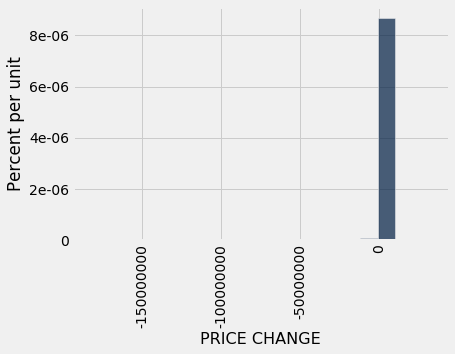

In [31]:
# Understand price difference data
col_stats(condo_sales, COL_PRICE_CHANGE)


There look to be some signifiant outliers here. The 99 percentile is 5 but the max is 44 MM a significant. The min value is -183MM, a 183 million dollor loss! 

Let's remove outliers so they dont imapact pricing analysis, but we definitely need to come back and look into what happened here. 

PRICE CHANGE Stats
Avg: 443344.4254254904 	Std: 689417.2831735029 	Min: -1500000 	Max: 5215563
 5%: -129980 	95%: 1715000
 1%: -640298 	99%: 3521675
25%: 85380 	50%: 255540 	75% 560963


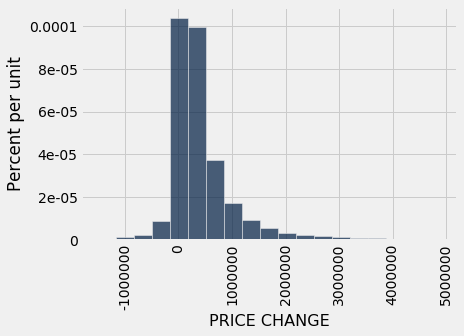

In [32]:
# strip out the Price chnage outliers . 
percent_1 = percentile(1, price_diffs)
percent_99 = percentile(99, price_diffs)

largest_losses = condo_sales.where(COL_PRICE_CHANGE, are.below_or_equal_to(percent_1))
largest_gains = condo_sales.where(COL_PRICE_CHANGE, are.above_or_equal_to(percent_99))

condo_sales = condo_sales.where(COL_PRICE_CHANGE, are.between(percent_1, percent_99))
col_stats(condo_sales, COL_PRICE_CHANGE)

The data is starting to look like a normal distribution

In [33]:
# Some sales are on recorded twice for the same date!

condo_sales.where( COL_PURCHASE_DATE, are.equal_to, COL_SOLD_DATE )


FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD
"1 IRVING PLACE, G27B",2017-12-14 00:00:00,1950000,2017-12-14 00:00:00,1950000,0,0
"1 IRVING PLACE, G9B",2017-12-14 00:00:00,1362500,2017-12-14 00:00:00,1362500,0,0
"1 RIVER TERRACE, 4S",2017-12-06 00:00:00,2790000,2017-12-06 00:00:00,2790000,0,0
"10 MADISON SQUARE WEST, 4F",2017-12-18 00:00:00,6950000,2017-12-18 00:00:00,6950000,0,0
"100 11TH AVENUE, 12B",2017-12-15 00:00:00,4300000,2017-12-15 00:00:00,4300000,0,0
"100 CENTRAL PARK SOUTH, 6A",2017-12-14 00:00:00,2025000,2017-12-14 00:00:00,2025000,0,0
"100 WEST 93RD STREET, 2G",2017-12-07 00:00:00,1250000,2017-12-07 00:00:00,1250000,0,0
"100/118 WEST 93RD STREET, 3E",2017-12-20 00:00:00,720000,2017-12-20 00:00:00,720000,0,0
"101 LEONARD STREET, 3D",2016-02-05 00:00:00,1812000,2016-02-05 00:00:00,2925000,"1,113,000",0
"101 WALL STREET, 6B",2017-12-19 00:00:00,2394160,2017-12-19 00:00:00,2394160,0,0


In [34]:
# Let's spot check these

all_sales_data.where(COL_FULL_ADDRESS, are.equal_to('100 CENTRAL PARK SOUTH, 4B')).sort(0)

# These look to be duplicate records, Let's ignore for now

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2017-11-14 00:00:00,2350000,100 CENTRAL PARK SOUTH,4B,0,MIDTOWN WEST,10019,R4,13 CONDOS - ELEVATOR APARTMENTS,"100 CENTRAL PARK SOUTH, 4B"


In [35]:
# Ignore multiple sales on same date

condo_sales = condo_sales.where( COL_PURCHASE_DATE, are.not_equal_to, COL_SOLD_DATE )



## Issues with time between sales

Looking into the time between 2 sales for the same apartment we find some unusal data

In [36]:
condo_sales.sort(COL_PERIOD)

FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD
"2 EAST 55TH ST, 835",2006-08-15 00:00:00,554946,2006-08-16 00:00:00,486720,"-68,226",1
"212 EAST 70TH STREET, 2D",2017-03-23 00:00:00,312500,2017-03-24 00:00:00,725000,"412,500",1
"95 CHARLES STREET, 5",2016-03-25 00:00:00,850000,2016-03-26 00:00:00,850000,0,1
"203-05 WEST 112 STREET, 1W",2003-12-17 00:00:00,967338,2003-12-19 00:00:00,967338,0,2
"238 EAST 47 STREET, 22D",2004-07-14 00:00:00,105000,2004-07-16 00:00:00,1100000,"995,000",2
"227 EAST 111 STREET, 5B",2005-03-28 00:00:00,540881,2005-03-31 00:00:00,995000,"454,119",3
"879-87 8 AVENUE, 2J",2003-11-13 00:00:00,620000,2003-11-16 00:00:00,620000,0,3
"157 WEST 111 STREET, 4E",2007-03-09 00:00:00,776925,2007-03-13 00:00:00,834965,"58,040",4
"500 WEST 43RD STREET, 24F",2014-01-03 00:00:00,800350,2014-01-07 00:00:00,800350,0,4
"10 EAST 14TH ST, 2",2007-01-04 00:00:00,1483300,2007-01-09 00:00:00,2698362,"1,215,062",5


Still Looks like there is some strange data where the sale dates are a few days apart, for most regular sale cycles we expect a gap of atleast 60-90 days. 
Let's ignore anything less that 3 months apart i.e. 90 days. 


In [37]:
condo_sales = condo_sales.where( COL_PERIOD, are.above(90) )

## Time between sales

PERIOD Stats
Avg: 2073.9143685523563 	Std: 1221.572522351763 	Min: 91 	Max: 5705
 5%: 316 	95%: 4259
 1%: 136 	99%: 5035
25%: 1072 	50%: 1938 	75% 2927


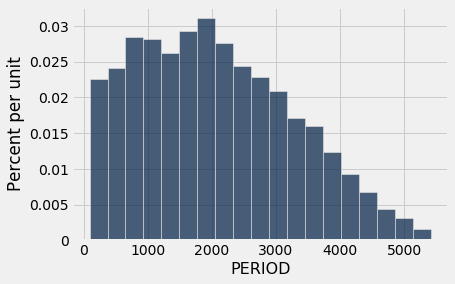

In [38]:
col_stats(condo_sales, COL_PERIOD)

## Average Daily Price Change

Let's calulate the average daily price change to spot any other odd data. 

In [39]:
daily_change = condo_sales.column(COL_PRICE_CHANGE) / condo_sales.column(COL_PERIOD) 

condo_sales = condo_sales.with_column(COL_DAILY_PRICE_CHANGE , daily_change ).sort(COL_DAILY_PRICE_CHANGE, descending=True)
condo_sales

FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD,DAILY PRICE CHANGE
"15 CENTRAL PARK WEST, 36B",2008-04-28 00:00:00,7473955,2008-09-03 00:00:00,12400000,"4,926,045",128,38484.7
"15 CENTRAL PARK WEST, 31B",2008-04-16 00:00:00,6598260,2008-10-03 00:00:00,11800000,"5,201,740",170,30598.5
"56 LEONARD STREET, PH55",2017-03-02 00:00:00,21814384,2017-08-04 00:00:00,26500000,"4,685,616",155,30229.8
"151 EAST 58 STREET, PH55E",2005-08-16 00:00:00,9622462,2005-12-15 00:00:00,13000000,"3,377,538",121,27913.5
"157 WEST 57TH STREET, 58A",2014-05-01 00:00:00,30551000,2014-10-02 00:00:00,34000000,"3,449,000",154,22396.1
"201 EAST 80TH STREET, 9A",2016-08-19 00:00:00,657401,2016-12-07 00:00:00,2995000,"2,337,599",110,21250.9
"19 BEACH STREET, 6",2018-02-28 00:00:00,2410796,2018-07-31 00:00:00,5500000,"3,089,204",153,20190.9
"250 WEST STREET, 7A",2013-03-18 00:00:00,6379336,2013-06-24 00:00:00,8200000,"1,820,664",98,18578.2
"212 WEST 18TH STREET, 18C",2014-12-23 00:00:00,5718750,2015-09-10 00:00:00,10414000,"4,695,250",261,17989.5
"554 BROOME ST, R6",2006-03-30 00:00:00,380250,2006-08-16 00:00:00,2850000,"2,469,750",139,17768


DAILY PRICE CHANGE Stats
Avg: 342.97710109338556 	Std: 1030.9512696208644 	Min: -13128.990566037735 	Max: 38484.7265625
 5%: -96.15646940822468 	95%: 1304.8415300546449
 1%: -590.6298904538342 	99%: 3534.2162162162163
25%: 50.44995909462776 	50%: 147.19228587634714 	75% 357.14285714285717


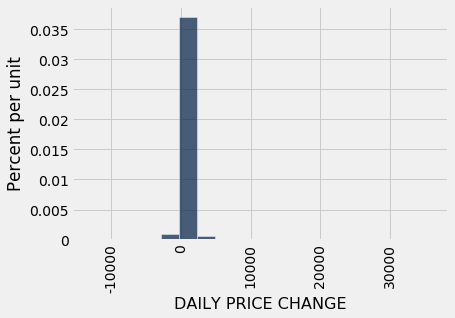

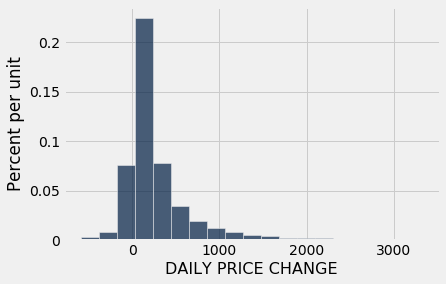

In [40]:
col_stats(condo_sales, COL_DAILY_PRICE_CHANGE)
draw_hist(condo_sales, COL_DAILY_PRICE_CHANGE, 1)

## There are some significant outliers

There could be a variety of reasons for the outliers. Perhaps they underpriced for when purchased and then corrected when sold later. Again I'd be intresting to investigate further, but for the purposes of this analysis let's ignore the outliers for now. 

In [41]:
# strip out the Dailys Price change outliers. 
price_change_diffs = condo_sales.column(COL_DAILY_PRICE_CHANGE)

percent_1 = percentile(1, price_change_diffs)
percent_99 = percentile(99, price_change_diffs)

condo_sales = condo_sales.where(COL_DAILY_PRICE_CHANGE, are.between(percent_1, percent_99))


# Step 3: NYC Sale data analysis

# Understanding the data

Let's try to get an overview of the data by looking at the movement of the average sale price per year.

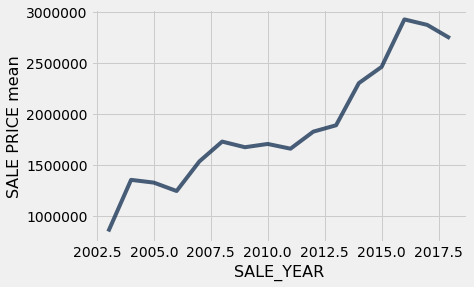

In [42]:
years = [ d.year for d in condos.column(COL_SALE_DATE) ]

months = [ d.month for d in condos.column(COL_SALE_DATE) ]

condos = condos.with_column('SALE_YEAR', years, 'SALE_MONTH', months)

condo_mean = condos.select(COL_SALE_YEAR, COL_SALE_PRICE).group(COL_SALE_YEAR, np.mean).sort(0)
condo_mean.plot(COL_SALE_YEAR)



## Sales by neighbourhood 

Also helpful to usederstand how prices have changed in different neighborhoods. 

In [43]:
neighborhoods = condos.group('NEIGHBORHOOD').sort(0).column(0)


def plot_neighborhood(neighborhood:str):
    '''Plot the average sale for a specified neign'''
    condos.where('NEIGHBORHOOD', are.equal_to(neighborhood)).select(COL_SALE_YEAR, COL_SALE_PRICE).group(0, np.mean).plot(0, label=neighborhood)
    plots.title = neighborhood
    plots.plot(condo_mean.column(0), condo_mean.column(1), color='gold', label='' )
    return

ignnore = interact(plot_neighborhood, neighborhood=neighborhoods)


interactive(children=(Dropdown(description='neighborhood', options=('ALPHABET CITY', 'CHELSEA', 'CHINATOWN', '…

## Sampling

Let's take a deeper dive at apartment sales in 2010 as a sample. Note: we could have selected any range. This is just a random selection to reduce the noise in the data



Correlation betweeen Price Change and Time:  0.11792291655136572


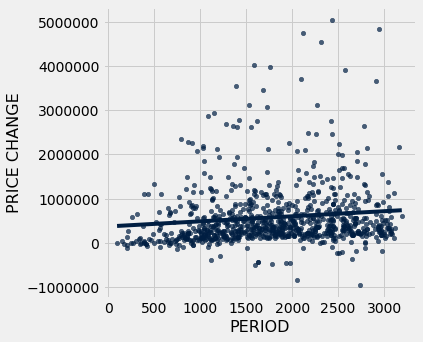

In [44]:
sales_2010 = condo_sales.where(COL_PURCHASE_DATE, are.between( datetime(2010, 1, 1), datetime(2010, 12, 31)))

Table().with_columns(
    'PERIOD',  sales_2010.column(COL_PERIOD), 
    'PRICE CHANGE', sales_2010.column(COL_PRICE_CHANGE)
).scatter(0, 1, fit_line=True)

print('Correlation betweeen Price Change and Time: ', correlation(sales_2010, COL_PERIOD, COL_PRICE_CHANGE))

That's a low correlation, I was expectating a closer relationship that is roghly keeping tracking with avg overall sale price we plotted earlier.


Ok, let's look at the correlation between the first and last sale price. 

0.9491242451642874

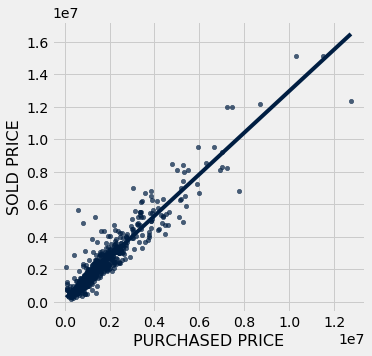

In [45]:
Table().with_columns(
    'PURCHASED PRICE',  sales_2010.column(COL_PURCHASE_PRICE), 
    'SOLD PRICE', sales_2010.column(COL_SOLD_PRICE)
).scatter(0, fit_line=True)

correlation(sales_2010, COL_PURCHASE_PRICE, COL_SOLD_PRICE)



Wow that's a really high correlation. According to this we could predict the last sale price of a property, just based on it's first sale price. i.e. independent of the time between sales! 

Somehting doesn't seem right, we know that the market moves over time. Let's dig in a little deeper and plot the residuals

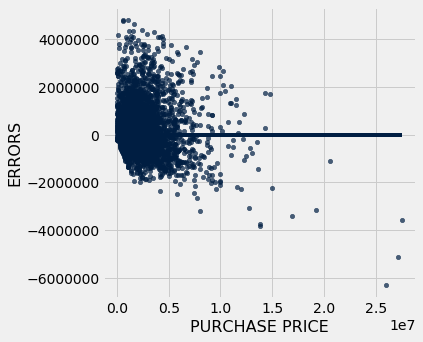

In [46]:
a = slope(condo_sales, COL_PURCHASE_PRICE, COL_SOLD_PRICE)
b = intercept(condo_sales, COL_PURCHASE_PRICE, COL_SOLD_PRICE)

first_prices = condo_sales.column(COL_PURCHASE_PRICE)

predicted = first_prices * a + b

errors = condo_sales.column(COL_SOLD_PRICE) - predicted


Table().with_columns(
    'PURCHASE PRICE',  condo_sales.column(COL_PURCHASE_PRICE), 
    'ERRORS', errors
).scatter(0, fit_line=True)



The residuals are not evenly spread put, also some large outliers are skewing the results so a liner regression model isn't the right approach here.

Let's take a deeper look into a particular price bands to see what could be going on. 

0.2706133032486955

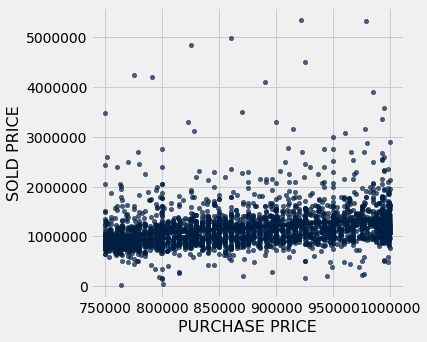

In [47]:
price_band = condo_sales.where(COL_PURCHASE_PRICE, are.between(750000, 1000000))

price_band.scatter(COL_PURCHASE_PRICE, COL_SOLD_PRICE, fit_line=True)
correlation(price_band, COL_PURCHASE_PRICE, COL_SOLD_PRICE)

Now the correlation is much lower, The data is more spread out. Also a average seems to skew a little higher do the outliers a visible in the chart.

## Removing Outliers

Let's look at the purchase price outliers

PURCHASE PRICE Stats
Avg: 1343091.4503921838 	Std: 1360571.5137068713 	Min: 11753 	Max: 27507062
 5%: 278850 	95%: 3625000
 1%: 143070 	99%: 6718423
25%: 580402 	50%: 935000 	75% 1634291


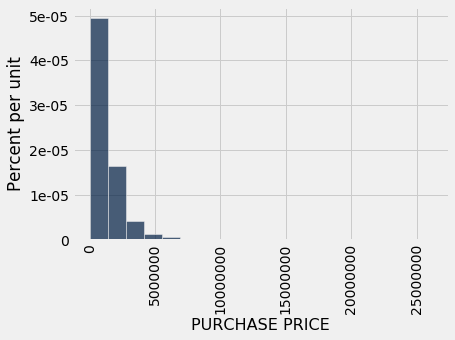

In [48]:
col_stats(condo_sales, COL_PURCHASE_PRICE)

Let's remove the ouliers so we can get a better picture of the data. 

PURCHASE PRICE Stats
Avg: 1271691.6471951134 	Std: 1024606.340964852 	Min: 143070 	Max: 6700000
 5%: 300000 	95%: 3371020
 1%: 200000 	99%: 5300000
25%: 588000 	50%: 935000 	75% 1619017


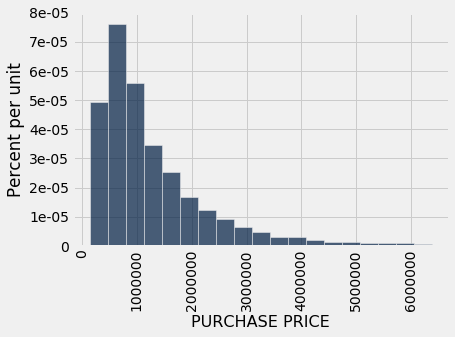

In [49]:
purchase_prices = condo_sales.column(COL_PURCHASE_PRICE)

percent_1 = percentile(1, purchase_prices)
percent_99 = percentile(99, purchase_prices)

condo_sales = condo_sales.where(COL_PURCHASE_PRICE, are.between(percent_1, percent_99))
col_stats(condo_sales, COL_PURCHASE_PRICE)

much better!

# Price change % 

Now let's calculate the price change as a % of the purchase price.

In [50]:
percents = sales_2010.column(COL_PRICE_CHANGE) / sales_2010.column(COL_PURCHASE_PRICE) * 100



sales_2010 = sales_2010.with_column(COL_PRICE_PERCENT, percents)



## Sanitize price change % 

Looking into how  the price change % data is distributed. Again we need to clean out the outliers.

PRICE CHANGE % Stats
Avg: 53.31361231031813 	Std: 128.100149791671 	Min: -60.02098971213591 	Max: 3054.111347465708
 5%: 0.0 	95%: 103.25
 1%: -31.03448275862069 	99%: 487.8787878787879
25%: 23.75 	50%: 39.285714285714285 	75% 57.05128205128205


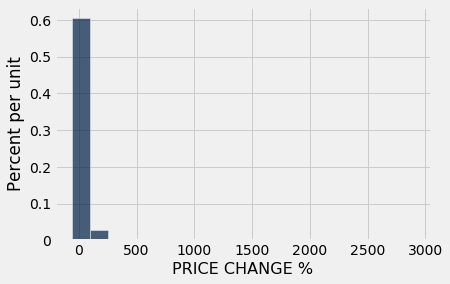

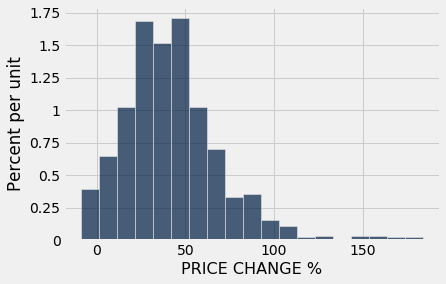

In [51]:

col_stats(sales_2010, COL_PRICE_PERCENT)
draw_hist(sales_2010, COL_PRICE_PERCENT, 2)

In [52]:
# strip out the Price Percent change outliers. 

price_changes = sales_2010.column(COL_PRICE_PERCENT)

percent_2 = percentile(2, price_changes)
percent_98 = percentile(98, price_changes)

sales_2010 = sales_2010.where(COL_PRICE_PERCENT, are.between(percent_2, percent_98))



0.33638955204814946

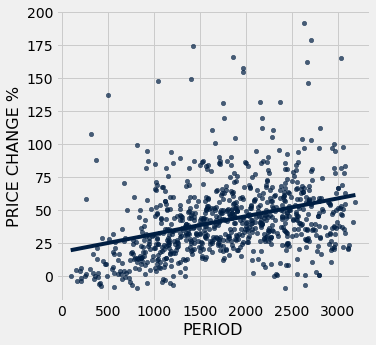

In [53]:
sales_2010.scatter(COL_PERIOD, COL_PRICE_PERCENT, fit_line=True)
correlation(sales_2010, COL_PERIOD, COL_PRICE_PERCENT)

Ok there there looks to be an upward trend here and prices changes increase over time. That said the correlation isn't linear. Smoothing the data into monthly (30) intervals look like the following

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


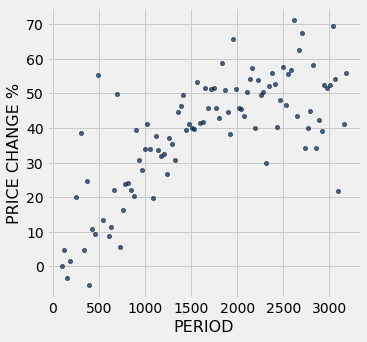

In [54]:

periods = sales_2010.column(COL_PERIOD)

min_period = min(periods)
max_period = max(periods)


period_groups = []
period_sales = []

for i in np.arange(min_period, max_period, 30 ):
    period_groups.append(i)
    period_sales.append(np.mean(sales_2010.where(COL_PERIOD, are.between(i, i+30)).column(COL_PRICE_PERCENT)))
    

Table().with_columns(
    COL_PERIOD,  period_groups, 
    COL_PRICE_PERCENT, period_sales
).scatter(0)

Defintitely shows a trend! 

Let's take a look at other years

In [55]:
# Trim the outliers. 
percents = condo_sales.column(COL_PRICE_CHANGE) / condo_sales.column(COL_PURCHASE_PRICE) * 100

condo_sales = condo_sales.with_column(COL_PRICE_PERCENT, percents)

percent_1 = percentile(1, percents)
percent_99 = percentile(99, percents)

condo_sales = condo_sales.where(COL_PRICE_PERCENT, are.between(percent_1, percent_99))

def plot_price_change_year(year):
    ''' Plot the price change % for a given year'''
    valid_sales = condo_sales.where(COL_PURCHASE_DATE, are.between_or_equal_to( datetime(year, 1, 1), datetime(year+1, 1, 1)))

    min_period = min(periods)
    max_period = max(periods)


    period_groups = []
    period_sales = []

    for i in np.arange(min_period, max_period, 30 ):
        period_groups.append(i)
        period_sales.append(np.mean(valid_sales.where(COL_PERIOD, are.between(i, i+30)).column(COL_PRICE_PERCENT)))

    Table().with_columns(
        COL_PERIOD,  period_groups, 
        COL_PRICE_PERCENT, period_sales
    ).scatter(0)

interact(plot_price_change_year, year=np.arange(2003,2019) )



interactive(children=(Dropdown(description='year', options=(2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 20…

<function __main__.plot_price_change_year(year)>

We can now say there is a a correlation between the price change and time reflective of the overall movement in the market over time. 

Let's create some prediction models. 

# Step 4: Predicting NYC property prices

## Prediction model: nearest neighbor

Our prediction model should use both the purchase price and date for prediction. Let's create it now.

We will first convert purchase date, price and sold dates into standard units so they can be used to compute distance. 

There we will create the training and testing set.

In [56]:
# Convert to standard units
purchase_dates_timestamps = [ date.timestamp() for date in condo_sales.column(COL_PURCHASE_DATE)]
purchase_dates_su = standard_units(purchase_dates_timestamps)

sold_dates_timestamps = [ date.timestamp() for date in condo_sales.column(COL_SOLD_DATE)]
sold_dates_su = standard_units(sold_dates_timestamps)

purchase_price_su = standard_units(condo_sales.column(COL_PURCHASE_PRICE))

condo_sales_su = condo_sales.with_column(
    COL_PURCHASE_DATE_SU, purchase_dates_su, 
    COL_PURCHASE_PRICE_SU, purchase_price_su, 
    COL_SOLD_DATE_SU, sold_dates_su,
)

# Create the training and testing sets.
training_sales, test_sales = condo_sales_su.split(int(condo_sales.num_rows * 0.6))
training_sales


FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD,DAILY PRICE CHANGE,PRICE CHANGE %,PURCHASE DATE SU,PURCHASE PRICE SU,SOLD DATE SU
"100 RIVERSIDE BOULEVARD, 17H",2008-07-14 00:00:00,1013158,2011-09-16 00:00:00,850000,"-163,158",1159,-140.775,-16.1039,0.226941,-0.262461,-0.499676
"1 MORTON SQUARE, 3D E",2004-01-14 00:00:00,1629200,2010-07-20 00:00:00,2050000,"420,800",2379,176.881,25.8286,-1.24269,0.336205,-0.808559
"340 EAST 23RD STREET, 11J",2008-03-11 00:00:00,534581,2012-02-13 00:00:00,542025,"7,444",1434,5.19107,1.39249,0.115131,-0.72754,-0.390143
"252 7 AVENUE, 11S",2003-01-16 00:00:00,755000,2012-05-09 00:00:00,1062500,"307,500",3401,90.4146,40.7285,-1.56738,-0.513338,-0.327344
"157 EAST 74TH STREET, 5B/5C",2007-01-11 00:00:00,4150000,2007-12-20 00:00:00,4795000,"645,000",343,1880.47,15.5422,-0.265022,2.78591,-1.49716
"230 RIVERSIDE DRIVE, 2L",2008-06-30 00:00:00,315000,2013-06-27 00:00:00,310000,"-5,000",1823,-2.74273,-1.5873,0.214418,-0.940928,-0.0250323
"150 NASSAU STREET, 5C",2003-05-14 00:00:00,328993,2012-05-02 00:00:00,668500,"339,507",3276,103.635,103.196,-1.46183,-0.92733,-0.332455
"450 EAST 83RD STREET, 5F",2008-02-01 00:00:00,710000,2016-03-01 00:00:00,700000,"-10,000",2951,-3.38868,-1.40845,0.0802464,-0.557069,0.689123
"230 RIVERSIDE DRIVE, 16K",2008-06-30 00:00:00,274000,2013-06-27 00:00:00,280000,"6,000",1823,3.29128,2.18978,0.214418,-0.980772,-0.0250323
"400 WEST 12TH STREET, 3H",2012-05-07 00:00:00,2925000,2015-02-04 00:00:00,2500000,"-425,000",1003,-423.729,-14.5299,1.47295,1.59546,0.403607


In [63]:
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
condo_sales_su.to_df().to_csv( output_directory + 'condo_sales.csv', index = False)


In [64]:
# Columns used to the calculate the distance between two point i.e. 2 properties that were purchased and sold. 
# We picked the purchase date & price and the sold date converted to standard units as the important columns
# to use for calculating the distance.
distance_columns = [COL_PURCHASE_DATE_SU, COL_PURCHASE_PRICE_SU, COL_SOLD_DATE_SU]



def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.select(distance_columns)
    return distance.cdist( attributes.to_array().tolist(), [new_point]).flatten()

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def estimate(training, purchase_point, k):
    """Estimate a price based on nearest neighbours"""
    close_points = closest(training_sales, purchase_point, k)
    avg_price_change = np.mean(close_points.column(COL_PRICE_PERCENT))
    return avg_price_change

def evaluate_accuracy(training, test, k):
    """Evalute the accuracy of the model generating using training data on test data"""
    # select the columns to compare
    test_attributes = test.select(distance_columns)

    # compute the predicted change for each test row
    def price_testrow(row):
        return estimate(training, row, k)

    # Calculate the predicted price and error
    c = test_attributes.apply(price_testrow)
    
    estimated = test[COL_PURCHASE_PRICE] * (100 + c )/100
    error = (test[COL_SOLD_PRICE] - estimated  ) / test[COL_SOLD_PRICE] * 100
    
    return test.with_column("Estimated", estimated, 'Error %', error)

In [65]:

sample_sales =  test_sales
estimates = evaluate_accuracy(training_sales, sample_sales, 10)


Error % Stats
Avg: -3.5397717677473506 	Std: 21.389822707595897 	Min: -185.51652323208972 	Max: 69.9753145695102
 5%: -38.265994648226204 	95%: 28.74770281954954
 1%: -67.53159484100112 	99%: 45.999987208959844
25%: -14.559246976251647 	50%: -2.4054065810023393 	75% 8.753609143155348


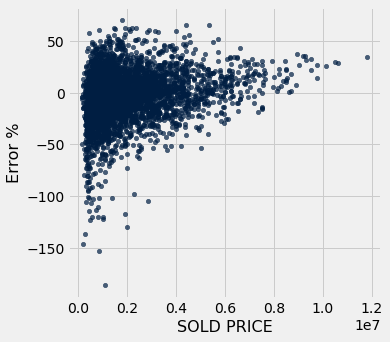

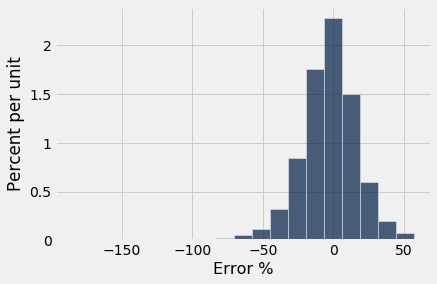

In [66]:
estimates.scatter(COL_SOLD_PRICE, 'Error %')

col_stats(estimates, "Error %")

In [67]:
estimates

FULL ADDRESS,PURCHASE DATE,PURCHASE PRICE,SOLD DATE,SOLD PRICE,PRICE CHANGE,PERIOD,DAILY PRICE CHANGE,PRICE CHANGE %,PURCHASE DATE SU,PURCHASE PRICE SU,SOLD DATE SU,Estimated,Error %
"200 WEST END AVENUE, 10M",2008-04-14 00:00:00,962246,2011-07-15 00:00:00,999000,"36,754",1187,30.9638,3.81961,0.145543,-0.311937,-0.54568,933044,6.60224
"1601 3 AVENUE, 18H",2003-02-20 00:00:00,420445,2008-04-09 00:00:00,1150000,"729,555",1875,389.096,173.52,-1.53607,-0.838457,-1.4161,962854,16.2736
"32 WEST 18TH STREET, 11B",2007-08-02 00:00:00,4378475,2015-09-15 00:00:00,6500000,"2,121,525",2966,715.282,48.4535,-0.0834429,3.00794,0.566446,5.92889e+06,8.78627
"65 EAST 96TH STREET, 11B",2013-12-16 00:00:00,2775000,2014-05-23 00:00:00,2902625,"127,625",158,807.753,4.5991,1.9989,1.44969,0.21594,3.72333e+06,-28.2747
"80 ELIZABETH STREET, 5F",2003-01-30 00:00:00,520000,2018-04-16 00:00:00,1200000,"680,000",5555,122.412,130.769,-1.55486,-0.74171,1.25577,1.15519e+06,3.73423
"300 CATHEDRAL PARKWAY, 16K",2005-08-12 00:00:00,495000,2011-03-24 00:00:00,356000,"-139,000",2050,-67.8049,-28.0808,-0.727467,-0.766005,-0.628195,574807,-61.4625
"200 EAST 58TH STREET, 5H",2004-06-24 00:00:00,900000,2008-05-02 00:00:00,1550000,"650,000",1408,461.648,72.2222,-1.09778,-0.372428,-1.39931,1.41077e+06,8.98275
"200 CHAMBERS STREET, 14D",2007-03-30 00:00:00,2464165,2017-01-23 00:00:00,3300000,"835,835",3587,233.018,33.9196,-0.195253,1.14762,0.928636,3.90135e+06,-18.2228
"407 EAST 12TH STREET, 1FNW",2008-07-03 00:00:00,1095000,2015-07-06 00:00:00,1100000,"5,000",2559,1.95389,0.456621,0.217101,-0.182928,0.514601,1.52595e+06,-38.7223
"366 WEST 11TH STREET, 3C",2014-12-15 00:00:00,1300000,2017-08-16 00:00:00,1100000,"-200,000",975,-205.128,-15.3846,2.32449,0.0162904,1.07833,1.46506e+06,-33.1869


In [68]:

accuracy = []

for i in np.arange(1, 3):
    estimates = evaluate_accuracy(training_sales, sample_sales, i)
    average = np.mean(estimates.column("Error %"))
    accuracy.append(average)
    
    
accuracy


[-4.253426480127161, -3.7583351429004823]

# Price Predictor

Check out the price predictor here. 

# Furhter Explorations

It would be interesting furhter explore this data by:

1. Applying different weights to the distanace calculations. e.g. The purchase price should be more important than the other attributes. 
2. Including location when calculating the distance between two properties. 
3. Including co-ops.

If you have suggestions or thoughts, I would appreciate if you share them using the questions section below. 

Thank you for reading!

In [76]:
all_sales_data.where('ADDRESS', are.containing('20 SUTTON PLACE')).sort('SALE DATE', descending=True).show()

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2018-07-26 00:00:00,1325000,"20 SUTTON PLACE SOUTH, 20C",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 20C"
2018-07-25 00:00:00,1375000,"20 SUTTON PLACE SOUTH, 7A&P5",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 7A&P5"
2018-07-11 00:00:00,757500,"20 SUTTON PLACE SOUTH, 1C",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 1C"
2018-07-10 00:00:00,1300000,"20 SUTTON PLACE SOUTH, 9B",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 9B"
2018-05-30 00:00:00,837500,"20 SUTTON PLACE SOUTH, 17B",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 17B"
2018-03-02 00:00:00,1355000,"20 SUTTON PLACE SOUTH, 12B",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 12B"
2018-01-30 00:00:00,1750000,"20 SUTTON PLACE SOUTH, 2C",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 2C"
2017-12-15 00:00:00,1810000,"20 SUTTON PLACE SOUTH, 14E",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 14E"
2017-12-15 00:00:00,1810000,"20 SUTTON PLACE SOUTH, 14E",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 14E"
2017-09-07 00:00:00,775000,"20 SUTTON PLACE SOUTH, 6E",,1953,MIDTOWN EAST,10022,D4,10 COOPS - ELEVATOR APARTMENTS,"20 SUTTON PLACE SOUTH, 6E"
